In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
import time
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
savepath = parentdir + '/data/'+time.strftime("%m_%d")+'/bimanual/'
if not os.path.exists(savepath):
    os.makedirs(savepath)

In [3]:
from visualizer import VisualModel
from simulator import HumanoidSimulator
from simple_planner import SimpleKneePlanner
import pinocchio
import numpy as np
pinocchio.switchToNumpyMatrix()

/home/jack/.local/lib/python2.7/site-packages/robot_properties_solo/config/package_config.ini
/home/jack/repos/humanoid/humanoid_property/urdf/humanoid.urdf
['/home/jack/repos/humanoid/humanoid_property']


# Load model 

In [4]:
# Define simulation steps
horizon_length = 5000
time_step = 1e-3

# Define control trajectory steps 
ctrl_time_step = 8e-3
print('total simulation steps: %d, simulation time interval %.3f s'%(horizon_length, time_step))

total simulation steps: 5000, simulation time interval 0.001 s


In [5]:
# Load pinocchio model
m = VisualModel(display=False)
x0, nq, nv, na = m.x0, m.nq, m.nv, m.na
lower, upper = m.getLimit()
torqueLower, torqueUpper = m.getTorqueLimit()

# Initial condition

Plan a simple knee trajectory to initialize the movement of robot

In [6]:
simpleKneePlanner = SimpleKneePlanner(x0, nq, nv, na, horizon_length)
kneeTraj = simpleKneePlanner.forward()

In [7]:
# Simulate optimal rollover trajectory
ss1 = HumanoidSimulator(horizon_length, display=False,timeStep=time_step)
ss1.initPose(x0, nq, nv, na)
forceArr, comArr, posArr, _, torqueArr, _, _, _, peArr, keArr, contactTime, forceKnot= ss1.simulateOptTraj(m, kneeTraj, kneeTraj,ctrlTimeStep=ctrl_time_step)

action knot @ 1411, action time: 1411.00 ms
contact knot @ 1778, contact time: 1778.00 ms


In [8]:
bimanual_hardware_traj = ss1.toHardwareTraj(posArr)
# bimanual_hardware_traj = posArr
# print(np.shape(bimanual_hardware_traj))
# print(bimanual_hardware_traj[:,-1])
np.savetxt(savepath+"bimanual_unplanned_initial_only_value.csv", bimanual_hardware_traj, delimiter=",")
np.savetxt(savepath+"bimanual_unplanned_initial_only_value_verify.csv", bimanual_hardware_traj.T, delimiter=",")

original data columns: 5000
converted data columns: 1667


In [ ]:
# # Plot simulated result of unplanned bimanual trajectory
# forceArr /=2.
# posInfo = []
# posInfo.append(posArr)
# posInfo.append(lower)
# posInfo.append(upper)

# torqueInfo = []
# torqueInfo.append(torqueArr)
# torqueInfo.append(torqueLower)
# torqueInfo.append(torqueUpper)

# ss1.plot(forceArr,comArr,posInfo, torqueInfo,savepath, time_step)

# # Plot potential energy and kinematic energy 
# from utils import plotter
# meArr = peArr + keArr
# eArr = np.vstack([peArr, keArr])
# eArr = np.vstack([eArr, meArr])
# eArr = eArr[:,1000:2500]
# # np.savetxt()
# drawer1 = plotter(eArr,v_line = [contactTime-1000], 
#         timeStep = 1e-3,
#         label=['potential energy', 'kinetic energy', 'mechanical energy'], 
#         xlabel='t (s)', 
#         ylabel='energy (J)', 
#         fileName=savepath+'energy.png')
# drawer1.multiTimePlot(isVisiable=True)

### Bimanual trajectory

#### Unplanned trajectory

In [9]:
s = HumanoidSimulator(horizon_length, display=False, timeStep=time_step)
s.initPose(x0, nq, nv, na)

# x2 is the state before contact
# x1 is not considered as it is the state when the fall action is trigerred
_, _, staticArr, x2, _, comLength, x1, handLength, timeLength,_,_,_,_,_  = s.simulate(m, kneeTraj, kneeTraj)
ctrl_horizon_length = timeLength//int(ctrl_time_step/time_step)
print('fall simulated knots: %d'%(timeLength))
print('fall control knots: %d, control time interval %.3f s'%(ctrl_horizon_length, ctrl_time_step))
# rolloverPlanner.saveTraj(np.matrix(tauRolloverTraj).T, savepath+'value.csv')

# s.plot(forceArr,comArr,savepath)
#ctrl_horizon_length-=9

CoM is pulled out of support polygon @ 1411
fall simulated knots: 367
fall control knots: 45, control time interval 0.008 s


In [18]:
from simulator import HumanoidSimulator
from simple_planner import SimpleShoulderPlanner

# To differentiate from rollover, here we are using a shoulder planner
simpleShoulderPlanner = SimpleShoulderPlanner(x1, nq, nv, na, 100)
tauTraj = simpleShoulderPlanner.forward()

ss3 = HumanoidSimulator(horizon_length, display=True,timeStep=time_step, view='side')
ss3.initPose(x0, nq, nv, na)
forceArr, comArr, posArr, velArr, torqueArr, qArr, forcePose, tauArr, peArr, keArr, contactTime, forceKnot = ss3.simulateOptTraj(m, kneeTraj, tauTraj,ctrlTimeStep=ctrl_time_step, videoPath=savepath)
print('maximum force is %.2f N'%np.amax(forceArr/2.))

action knot @ 1411, action time: 1411.00 ms
contact knot @ 1767, contact time: 1767.00 ms
maximum force is 223.68 N


/home/jack/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


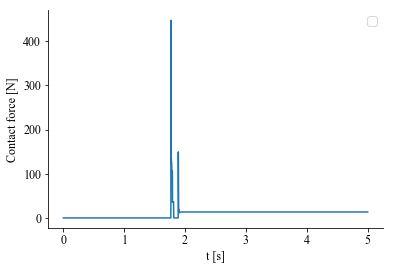

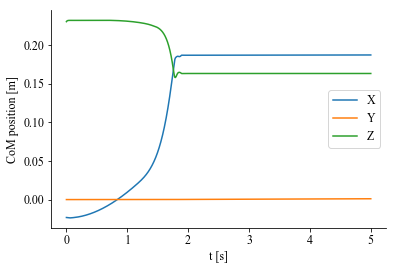

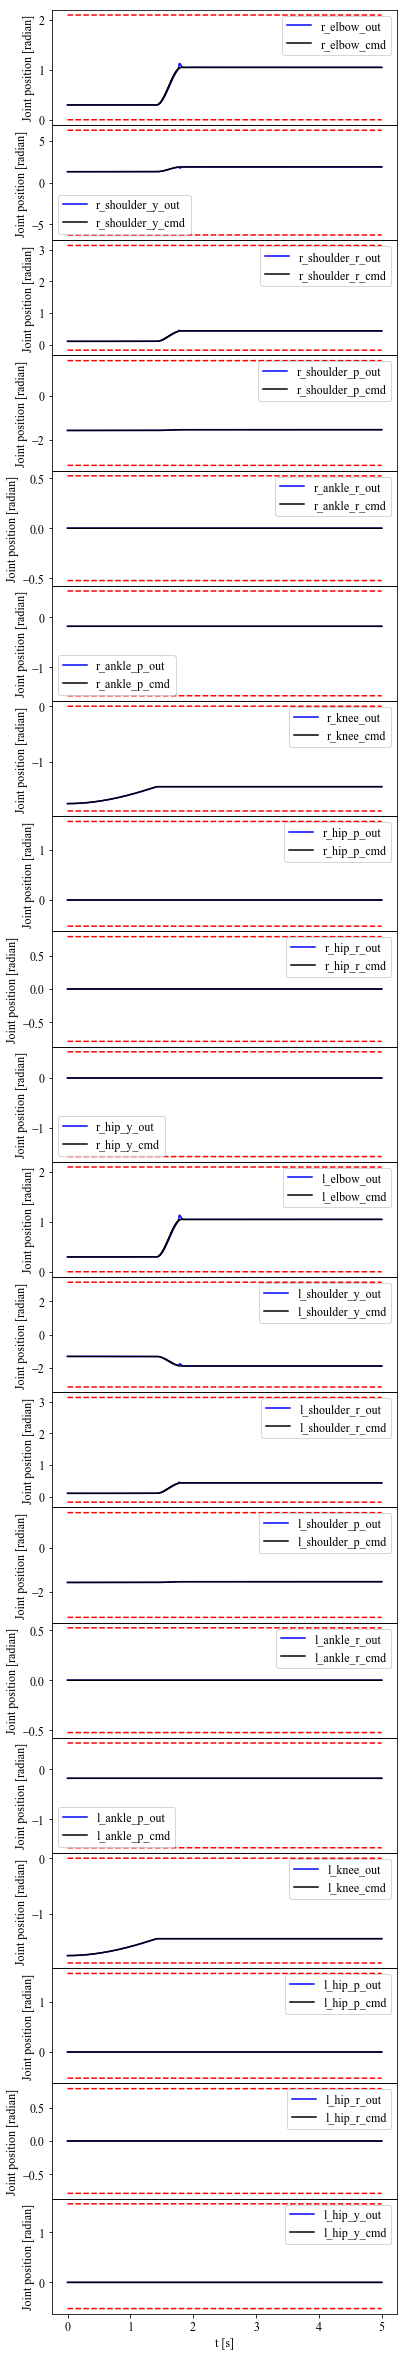

In [16]:
velLower, velUpper = m.getVelLimit()
posInfo = []
posInfo.append(posArr)
posInfo.append(lower)
posInfo.append(upper)

simVelInfo = []
simVelInfo.append(velArr)
simVelInfo.append(velLower)
simVelInfo.append(velUpper)

ocVelInfo = []
ocVelInfo.append(velArr)
ocVelInfo.append(velLower)
ocVelInfo.append(velUpper)

torqueInfo = []
torqueInfo.append(torqueArr)
torqueInfo.append(torqueLower)
torqueInfo.append(torqueUpper)

cmpInfo = []
cmpInfo.append(posArr)
cmpInfo.append(tauArr)
cmpInfo.append(lower)
cmpInfo.append(upper)

cmpInfo = []
cmpInfo.append(posArr)
cmpInfo.append(tauArr)
cmpInfo.append(lower)
cmpInfo.append(upper)

ss3.plot(forceArr,comArr,posInfo, simVelInfo, ocVelInfo, torqueInfo,savepath, time_step, cmpInfo=cmpInfo)

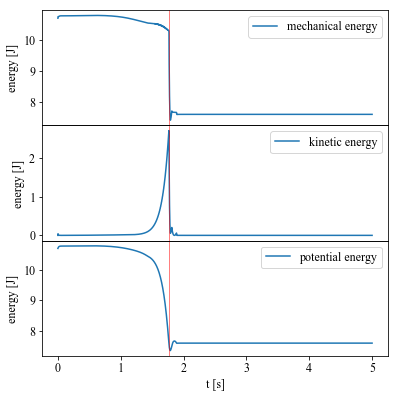

In [17]:
# Plot potential energy and kinematic energy
from utils import plotter
meArr = peArr + keArr
eArr = np.vstack([peArr, keArr])
eArr = np.vstack([eArr, meArr])

# start = 1000
# end = 2000

# eArr = eArr[:,start:end]
# contactTime = 2400
drawer1 = plotter(eArr, v_line=[contactTime],
        timeStep = 1e-3,
        legend=['potential energy', 'kinetic energy', 'mechanical energy'], 
        xlabel='t [s]', 
        ylabel='energy [J]', 
        fileName=savepath+'energy.png')
drawer1.multiTimePlot(isVisiable=True)

In [ ]:
# ctrl_horizon_length -= 10
print('target hand length in x direction %.3f'%handLength[0])
print('target hand length in y direction %.3f'%handLength[1])
print('target hand length in z direction %.3f'%handLength[2])

print('target com length in x direction %.3f'%comLength[0])
print('target com length in y direction %.3f'%comLength[1])
print('target com length in z direction %.3f'%comLength[2])

handLength1 = handLength.copy()
comLength1 = comLength.copy()
# handLength1[1] +=0.045
# handLength1[0] -=0.02

#### optimal trajectory

In [ ]:
from simple_planner import SimpleKneePlanner
from bimanual_planner import BimanualPlanner

bimanualPlanner = BimanualPlanner(x1, nq, nv, na, ctrl_horizon_length, contact_index=0, timeStep=ctrl_time_step, display=True)
tauBimanualTraj, velTraj = bimanualPlanner.forward(m, handLength1, comLength1)
tauBimanualTraj_index = bimanualPlanner.contact_index
# rolloverPlanner.saveTraj(np.matrix(tauRolloverTraj).T, savepath+'value.csv')
# rolloverPlanner.saveSwConfig(savepath+'equations.txt')
# print(ctrl_horizon_length)
print('Bimanual optimal trajectory length(columns): %d'%tauBimanualTraj.shape[1])

In [ ]:
# bimanualPlanner.displayTraj(m)

In [ ]:
def dup_cols(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[:,[indx]],axis=1)
# print(tauBimanualTraj)
tau = dup_cols(tauBimanualTraj, indx=0, num_dups=0)
# tau = dup_cols(tauBimanualTraj, indx=0, num_dups=100)

Simulate optimal trajectory

In [ ]:
from simulator import HumanoidSimulator


# Simulate optimal rollover trajectory
ss = HumanoidSimulator(horizon_length, display=True,timeStep=time_step,view='side')
ss.initPose(x0, nq, nv, na)
# print(x0)
forceArr, comArr, posArr,_, torqueArr, qArr, _, _, peArr, keArr,contactTime,_= ss.simulateOptTraj(m, kneeTraj, tau,ctrlTimeStep=ctrl_time_step, isBimanual=True,videoPath=savepath)
print('maximum force is %.2f N'%np.amax(forceArr/2.))

In [ ]:
# import pybullet as p
# p.disconnect()

In [ ]:
# Plot potential energy and kinematic energy
from utils import plotter
# drawer1 = plotter(qArr[3:6,:],v_line = [contactTime], 
#         timeStep = 1e-3,
#         label=['X', 'Y', 'Z'], 
#         xlabel='t [s]', 
#         ylabel='angle [radian]', 
#         fileName=savepath+'imu.png')
# drawer1.multiTimePlot(isVisiable=True)

drawer = plotter(qArr[3:6,:],v_line = [contactTime],
                timeStep = 1e-3,
                legend=['X','Y','Z'], 
                xlabel='t [s]', 
                ylabel='angluar position [$^\circ$]', 
                fileName=savepath+'imu.png')
drawer.timePlot()

In [ ]:
# Plot simulated result
forceArr /=2.

posInfo = []
posInfo.append(posArr)
posInfo.append(lower)
posInfo.append(upper)

torqueInfo = []
torqueInfo.append(torqueArr)
torqueInfo.append(torqueLower)
torqueInfo.append(torqueUpper)

ss.plot(forceArr,comArr,posInfo, torqueInfo,savepath, time_step)

In [ ]:
# Plot potential energy and kinematic energy
from utils import plotter
meArr = peArr + keArr
eArr = np.vstack([peArr, keArr])
eArr = np.vstack([eArr, meArr])
# print(peArr[0,forceKnot], keArr[0,forceKnot])
# print(peArr[0,contactTime-1], keArr[0,contactTime-1])
# eArr = eArr[:,1000:2500]
# np.savetxt()
drawer1 = plotter(eArr,v_line = [contactTime], 
        timeStep = 1e-3,
        legend=['potential energy', 'kinetic energy', 'mechanical energy'], 
        xlabel='t [s]', 
        ylabel='energy (J)', 
        fileName=savepath+'energy.png')
drawer1.multiTimePlot(isVisiable=True)
pe_filename = 'bimanual_optimal_value_pe.npy'
ke_filename = 'bimanual_optimal_value_ke.npy'
me_filename = 'bimanual_optimal_value_me.npy'
np.save(savepath+pe_filename, peArr)
np.save(savepath+ke_filename, keArr)
np.save(savepath+me_filename, meArr)

In [ ]:
bimanual_hardware_traj = ss.toHardwareTraj(posArr)
timestr = time.strftime("%m_%d_%H_%M")
filename = 'bimanual_optimal_value_'+timestr+'.csv'
filename_verify = 'bimanual_optimal_value_'+timestr+'_verify.csv'
np.savetxt(savepath+filename, bimanual_hardware_traj, delimiter=",")
np.savetxt(savepath+filename_verify, bimanual_hardware_traj.T, delimiter=",")
ss.downloadTraj(savepath+filename)